# Generalized additive models (GAMs)

Linear regression assumes relationships are straight lines. Real data rarely cooperates. At the edge between statistics and machine learning, a generalized additive model (GAM) can tackle this with its flexibiiy, its interpretability and its statistical rigor. GAMs add up smooth functions $f_j$ on individual variables as

$$y = \beta_0 + f_1(x_1) + f_2(x_2) + ... + f_p(x_p) + \varepsilon$$

The `tangent/ds` GAM implementation was inspired by the `mgcv` R package and by Noam Ross's course [GAMs in R](https://noamross.github.io/gams-in-r-course/). Although not as featured as `mgcv`, `tangent/ds` GAMs can model with multiple basis types (B-splines, cubic regression splines, truncated power), automatic smoothness selection (GCV, REML) and statistical inference (EDF, p-values, confidence intervals).

In [1]:
// Setup DOM for plotting in Jupyter with Deno
import { Window } from 'https://esm.sh/happy-dom@12.10.3';
const window = new Window();
globalThis.document = window.document;
globalThis.HTMLElement = window.HTMLElement;

// import packages
import * as ds from '../../src/index.js';
import * as Plot from '@observablehq/plot';
undefined; // avoids large outcomes from imports

## A non-linear regression

Let's fit a made-up sine wave. It's a classic non-linear pattern that linear regression fails on.

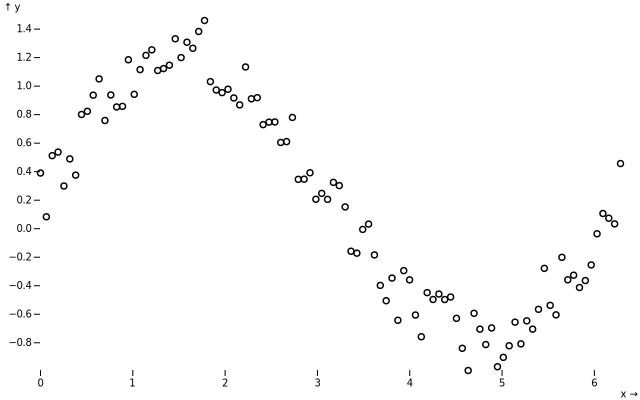

In [2]:
// Generate sine wave data with noise
const x_sine = [];
const y_sine = [];
const n_data = 100;
for (let i = 0; i < n_data; i++) {
  const x = (i / (n_data - 1)) * 2 * Math.PI;
  x_sine.push([x]);
  y_sine.push(Math.sin(x) + Math.random() * 0.5);
}

const xy_sine = x_sine.map((row, i) => ({x:row[0], y:y_sine[i]}));

Plot.plot({ marks: [ Plot.dot(xy_sine, { x: "x", y: "y" }) ] });

By default, `ds.ml.GAMRegressor` uses a truncated power basis (`tp`), no smoothness penalty and 4 spline knots. We can of course modify them (4 is quite low for a 1-cycle sine).

R2: 0.881


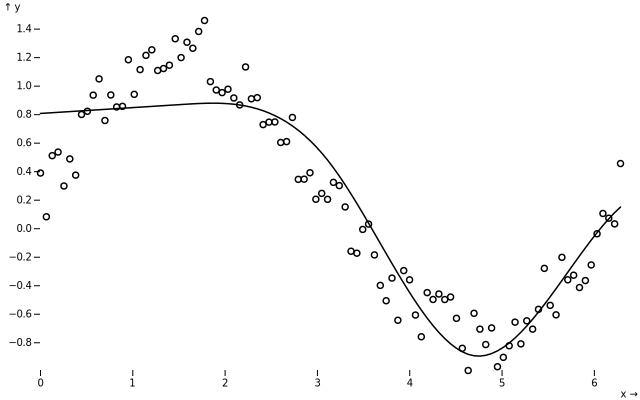

In [3]:
// Fit basic GAM
const gam_basic = new ds.ml.GAMRegressor({ nSplines: 4 });
gam_basic.fit(x_sine, y_sine);

// Predict on fine grid
const n_pred = 100;
const x_pred = [];
for (let i = 0; i < n_pred; i++) {
  x_pred.push([(i / (n_pred-1)) * 2 * Math.PI]);
}

const y_pred_basic = gam_basic.predict(x_pred);
console.log('R2:', gam_basic.gam.r2.toFixed(3));

const xy_pred_basic = x_pred.map((row, i) => ({x:row[0], y:y_pred_basic[i]}));
Plot.plot({ 
  marks: [ 
    Plot.line(xy_pred_basic, { x: "x", y: "y" }),
    Plot.dot(xy_sine, { x: "x", y: "y" })
  ]
});

We might want to fit with automatic smoothness (GCV) to find the right amount of smoothing: too little smoothing misses real patterns, too much smoothing fits noise, and GCV balances the trade-off. 

R2: 0.964
Effective degrees of freedom: 9.82
Proportion of flexibility used: 0.20


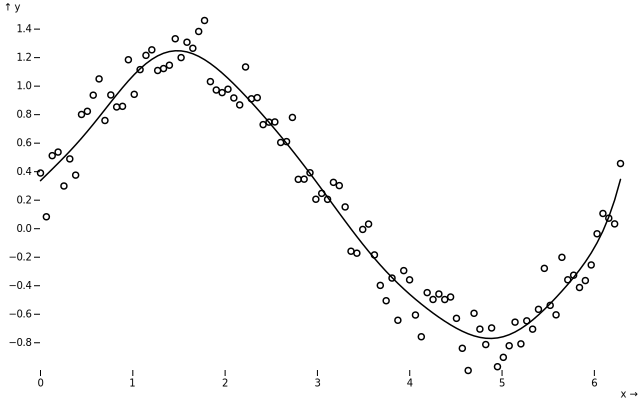

In [4]:
// Fit GAM with GCV smoothness selection
const n_splines = 50; // too many (the max allowed is 99)
const gam_gcv = new ds.ml.GAMRegressor({
  nSplines: n_splines,
  basis: 'tp',
  smoothMethod: 'GCV', // penalizes wiggliness
  lambda: 1
});

gam_gcv.fit(x_sine, y_sine);
const y_pred_gcv = gam_gcv.predict(x_pred);
console.log('R2:', gam_gcv.gam.r2.toFixed(3));
console.log('Effective degrees of freedom:', gam_gcv.gam.edf.toFixed(2));
console.log('Proportion of flexibility used:', (gam_gcv.gam.edf / n_splines).toFixed(2));

const xy_pred_gcv = x_pred.map((row, i) => ({x:row[0], y:y_pred_gcv[i]}));
Plot.plot({ 
  marks: [ 
    Plot.line(xy_pred_gcv, { x: "x", y: "y" }),
    Plot.dot(xy_sine, { x: "x", y: "y" })
  ]
});

GAMs provide rich information for statiscical inference.

In [5]:
gam_gcv.summary();

{
  call: "GAM fitted with penalized regression splines (GCV)",
  coefficients: {
    intercept: 0.3369359258721321,
    se: 0.06141696809240978,
    tValue: 5.486039710803835,
    pValue: 4.120468966029023e-8
  },
  smoothTerms: [
    {
      term: "s(x0)",
      edf: 4.112418000045365,
      refDf: 53,
      pValue: 0.19560215928962116
    }
  ],
  residualStdError: 0.14079600109823415,
  rSquared: 0.9640719548434611,
  devExplained: 0.9640719548434611,
  edf: 9.81885113627785,
  n: 100
}

The `edf` is the effective degrees of freedom. It tells how "wiggly" the smooth is, EDF ≈ 1 being almost linear, EDF ≈ 2-3 meaning modest curvature and EDF > 5 meaning complex non-linearity. The `pValue` test the signifiance of smooth terms. While there is variability in interpreting p-values, it's crucial to emphasize that p-values are not definitive indicators of "real" effects. A p-value less than 0.05 (or another threshold) does not guarantee that a real effect exists; it merely suggests that the observed data is unlikely under the null hypothesis, which is the baseline no effect status quo under the tested model. The `rSquared` is the proportion of variance explained, just like a linear regression.

We can quantify uncertainty in predictions using confidence intervals.

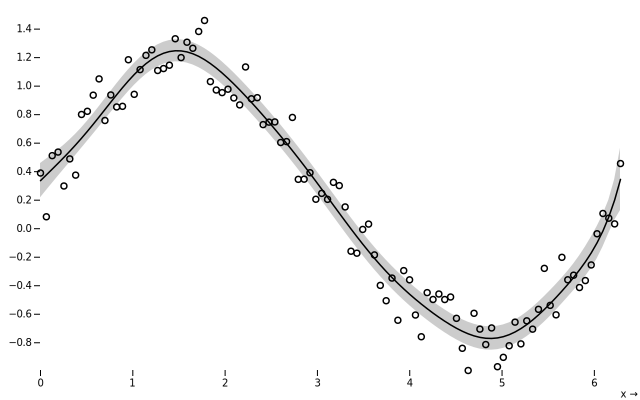

In [6]:
// Predictions with 95% confidence intervals
const y_pred_gcv_ci = gam_gcv.predictWithInterval(x_pred, 0.95);

// add the x field to the object
y_pred_gcv_ci.forEach((d, i) => { // beware that .forEach is inplace, we don't need to reassign
  d.x = x_pred[i][0];
});

// plot with confidence band
Plot.plot({ 
  marks: [ 
    Plot.areaY(y_pred_gcv_ci, { x: "x", y1: "lower", y2: "upper", opacity: 0.2}),
    Plot.line(y_pred_gcv_ci, { x: "x", y: "fitted" }),
    Plot.dot(xy_sine, { x: "x", y: "y" })
  ]
});

## Multiple predictors

GAMs naturally handle multiple features with additive smooths.

In [7]:
// Generate data with two predictors
const n_multi_data = 100;
const X_multi = [];
const y_multi = [];

// fill made up data
for (let i = 0; i < n_multi_data; i++) {
  const x1 = (i / (n_multi_data-1)) * 2 * Math.PI;
  const x2 = (i % 20) / 19 * Math.PI;
  
  X_multi.push([x1, x2]);
  y_multi.push(
    Math.sin(x1) + 0.5 * Math.cos(2 * x2) + (Math.random() - 0.5) * 0.15
  );
}

// Fit GAM with multiple smooths
const gam_multi = new ds.ml.GAMRegressor({basis: 'cr', nSplines: 8});

gam_multi.fit(X_multi, y_multi);
gam_multi.summary();

{
  call: "GAM fitted with regression splines",
  coefficients: {
    intercept: 0.48059341108236014,
    se: 0.0495021734564041,
    tValue: 9.708531515401285,
    pValue: 0
  },
  smoothTerms: [
    {
      term: "s(x0)",
      edf: 2.7356871438481853,
      refDf: 12,
      pValue: 0.2676883693664683
    },
    {
      term: "s(x1)",
      edf: 2.894131204961248,
      refDf: 12,
      pValue: 0.2567966890088264
    }
  ],
  residualStdError: 0.162441058175426,
  rSquared: 0.966578026672929,
  devExplained: 0.966578026672929,
  edf: 21,
  n: 100
}

The summary shows

- that each feature gets its own smooth function: $y = f_1(x_1) + f_2(x_2)$,
- non-linear each effect in the EDF, and
- p-values test if each smooth is significant

## Classification

GAMs work for classification too. Let's recover the penguins data set and preprocess it.

In [8]:
const penguinsResponse = await fetch(
  'https://cdn.jsdelivr.net/npm/vega-datasets@2/data/penguins.json',
);
const penguinsDataRaw = await penguinsResponse.json();
const penguinsData = penguinsDataRaw // there is a row with a "." instead of null in the Sex field
  .map(row => row.Sex === '.' ? { ...row, Sex: null } : row)
  .filter(row => row.Sex);

const prenguinsRecipe = ds.ml.recipe({
    data: penguinsData,
    X: ["Beak Length (mm)", "Beak Depth (mm)", "Flipper Length (mm)", "Body Mass (g)", "Sex"],
    y: "Species",
  })
  .oneHot(['Sex'])
  .split({ ratio: 0.7, shuffle: true, seed: 42 });

const penguinsPrepped = prenguinsRecipe.prep();

Just like in the ml notebook, we must use another class of model, `ds.ml.GAMClassifier`, then use a similar approch afterwards.

In [9]:
// define the model
const gamClassifier = new ds.ml.GAMClassifier({
  nSplines: 8,
  basis: 'cr',
  smoothMethod: 'GCV'
});

// fit
gamClassifier.fit({
  data: penguinsPrepped.train.data,
  X: penguinsPrepped.train.X,
  y: penguinsPrepped.train.y,
  encoders: penguinsPrepped.train.metadata.encoders  // Now finds encoders.y!
});

// predict
const penguinsPredSpecies = gamClassifier.predict({
  data: penguinsPrepped.test.data,
  X: penguinsPrepped.test.X
});

// compute the true test species
const penguinsTrueSpecies = penguinsPrepped.test.data.map(row => row.Species);

// confusion matrix
console.log(ds.ml.metrics.confusionMatrixText(penguinsTrueSpecies, penguinsPredSpecies));

//ds.plot.plotConfusionMatrix(penguinsTrueSpecies, penguinsPredSpecies).show(Plot)

Predicted:
           AdelieChinstrapGentoo
Actual:
  Adelie       42    4    2
  Chinstrap     5   13    0
  Gentoo        4    0   30

Accuracy: 85/100 = 85.00%

Per-class accuracy:
  Adelie   : 42/48 = 87.50%
  Chinstrap: 13/18 = 72.22%
  Gentoo   : 30/34 = 88.24%


## Practical Tips

GAMs are good at finding relationships are clearly non-linear. They are interpretable, they are amenable to statistical testing, and they are good with small sample sizes. However, there are better options when there are interactions between features (they have one function per variable, so the response to a feature is independant of the whole feature state), the number of feature grows (> 20), and when brute predictive power is all we need.

As for parameters,

`nSplines`:
- Start with 4-8
- Increase if residuals show patterns
- Too many → overfitting (use smoothness penalty!)

`smoothMethod`:
- `null`: No penalty (only if you know nSplines is right)
- `'GCV'`: General purpose, fast
- `'REML'`: When inference is critical

`basis`:
- `tp`: Simple, stable for gentle curves
- `cr`: Good default for most problems, but behaves badly on domain boundaries
- `bs`: Numerically stable for complex shapes, numerical stability, also behaves badly on domain boundaries

`lambda (fixed penalty)`:
- Small (0.001-0.01): Light smoothing
- Medium (0.1-1): Moderate smoothing
- Large (10+): Heavy smoothing (almost linear)